In [109]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests

In [110]:
df = pd.read_csv('Meteorite_Landings.csv', index_col=0)
df = df.dropna() # dropping all null rows

In [111]:
# Lets break up year column into just years
y = list()

for index, row in df.iterrows():
  y.append(row['year'][6:10])

df['years'] = y
df["years"] = pd.to_numeric(df["years"])

df = df.loc[df.years > 1900]

df.head()

id nametype     recclass  ...    reclong           GeoLocation years
name                                 ...                                       
Aarhus      2    Valid           H6  ...   10.23333  (56.18333, 10.23333)  1951
Abee        6    Valid          EH4  ... -113.00000    (54.21667, -113.0)  1952
Acapulco   10    Valid  Acapulcoite  ...  -99.90000     (16.88333, -99.9)  1976
Achiras   370    Valid           L6  ...  -64.95000   (-33.16667, -64.95)  1902
Adhi Kot  379    Valid          EH4  ...   71.80000          (32.1, 71.8)  1919

[5 rows x 10 columns]

In [112]:
# for the map description, lets add a description column
df['Description'] = "Mass: " + df['mass (g)'].astype(str) + ", Name: " + df.index.values.astype(str)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


id nametype  ... years                    Description
name                        ...                                     
Aarhus          2    Valid  ...  1951      Mass: 720.0, Name: Aarhus
Abee            6    Valid  ...  1952     Mass: 107000.0, Name: Abee
Acapulco       10    Valid  ...  1976   Mass: 1914.0, Name: Acapulco
Achiras       370    Valid  ...  1902     Mass: 780.0, Name: Achiras
Adhi Kot      379    Valid  ...  1919   Mass: 4239.0, Name: Adhi Kot
...           ...      ...  ...   ...                            ...
Zillah 002  31356    Valid  ...  1990  Mass: 172.0, Name: Zillah 002
Zinder      30409    Valid  ...  1999       Mass: 46.0, Name: Zinder
Zlin        30410    Valid  ...  1939          Mass: 3.3, Name: Zlin
Zubkovsky   31357    Valid  ...  2003  Mass: 2167.0, Name: Zubkovsky
Zulu Queen  30414    Valid  ...  1976  Mass: 200.0, Name: Zulu Queen

[37393 rows x 11 columns]

In [113]:
df_fell = df[(df['fall'] == 'Fell')]
df_fell

id nametype  ... years                        Description
name                          ...                                         
Aarhus            2    Valid  ...  1951          Mass: 720.0, Name: Aarhus
Abee              6    Valid  ...  1952         Mass: 107000.0, Name: Abee
Acapulco         10    Valid  ...  1976       Mass: 1914.0, Name: Acapulco
Achiras         370    Valid  ...  1902         Mass: 780.0, Name: Achiras
Adhi Kot        379    Valid  ...  1919       Mass: 4239.0, Name: Adhi Kot
...             ...      ...  ...   ...                                ...
Zemaitkiemis  30399    Valid  ...  1933  Mass: 44100.0, Name: Zemaitkiemis
Zhaodong      30404    Valid  ...  1984      Mass: 42000.0, Name: Zhaodong
Zhovtnevyi    30407    Valid  ...  1938   Mass: 107000.0, Name: Zhovtnevyi
Zhuanghe      30408    Valid  ...  1976       Mass: 2900.0, Name: Zhuanghe
Zvonkov       30415    Valid  ...  1955        Mass: 2568.0, Name: Zvonkov

[674 rows x 11 columns]

In [114]:
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'figure.figsize': (15, 8)}) 

# for coordinates
import requests
from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point

In [115]:
# reverse-geo locating coordinates to countries
# using github which was faster than google api
geoData = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()
country_list = list()

geo = df["GeoLocation"].values.tolist()
lat = df["reclat"].values.tolist()
lon = df["reclong"].values.tolist()

# stripping and cleaning up data coordinates
geo = [i.strip('()') for i in geo]
geo = [i.replace(' ', "") for i in geo]
geo = [i.replace(',', " ") for i in geo]
geo = [i.split(' ') for i in geo]
for i in range(len(geo)):
  geo[i][0] = float(geo[i][0])
  geo[i][1] = float(geo[i][1])

strtemp = " ".join([str(i) for i in geo])
geo = strtemp.replace("[", "").replace("]", "").replace(",", " ").replace("  ", " ").split(" ")

countries = {}
for i in geoData["features"]:
    geom = i["geometry"]
    country = i["properties"]["ADMIN"]
    countries[country] = prep(shape(geom))

def get_country(lon, lat):
    point = Point(lon, lat)
    for country, geom in countries.items():
        if geom.contains(point):
            return country
    return "unknown"

print("(This might take a second)...searching coordinates...assigning country names...\n")

# make list of countries if coordinates are known
for i in range(len(lon)):
  if get_country(lat[i], lon[i]) != "unknown":
    country_list.append(get_country(lat[i], lon[i]))
  else:
    country_list.append("Unknown")
  
# adding a country column
df["country"] = country_list

# Displays country with most/least frequent landings

countries = list()

for i in country_list:
    if i not in countries and i != "Unknown":
        countries.append(i)
        
cc = [i for i in country_list if i != "Unknown"]
biggest_country = max(set(cc), key = cc.count) 
smallest_country = min(set(cc), key = cc.count) 

print("Country with the most frequent landings is:", biggest_country)
print("Country with the least frequent landings is:", smallest_country)

(This might take a second)...searching coordinates...assigning country names...

Country with the most frequent landings is: Sudan
Country with the least frequent landings is: Senegal


In [116]:
# dropping unknown countries
df = df[df.country != "Unknown"]
df

id  ...                   country
name                     ...                          
Aioun el Atrouss    423  ...                    Angola
Aïr                 424  ...  Central African Republic
Akwanga             432  ...                   Nigeria
Al Zarnkh           447  ...                     Libya
Alberta             454  ...                   Algeria
...                 ...  ...                       ...
Zerhamra          30403  ...                    Rwanda
Zillah 001        31355  ...                     Sudan
Zillah 002        31356  ...                     Sudan
Zinder            30409  ...                  Cameroon
Zlin              30410  ...                     Yemen

[3765 rows x 12 columns]

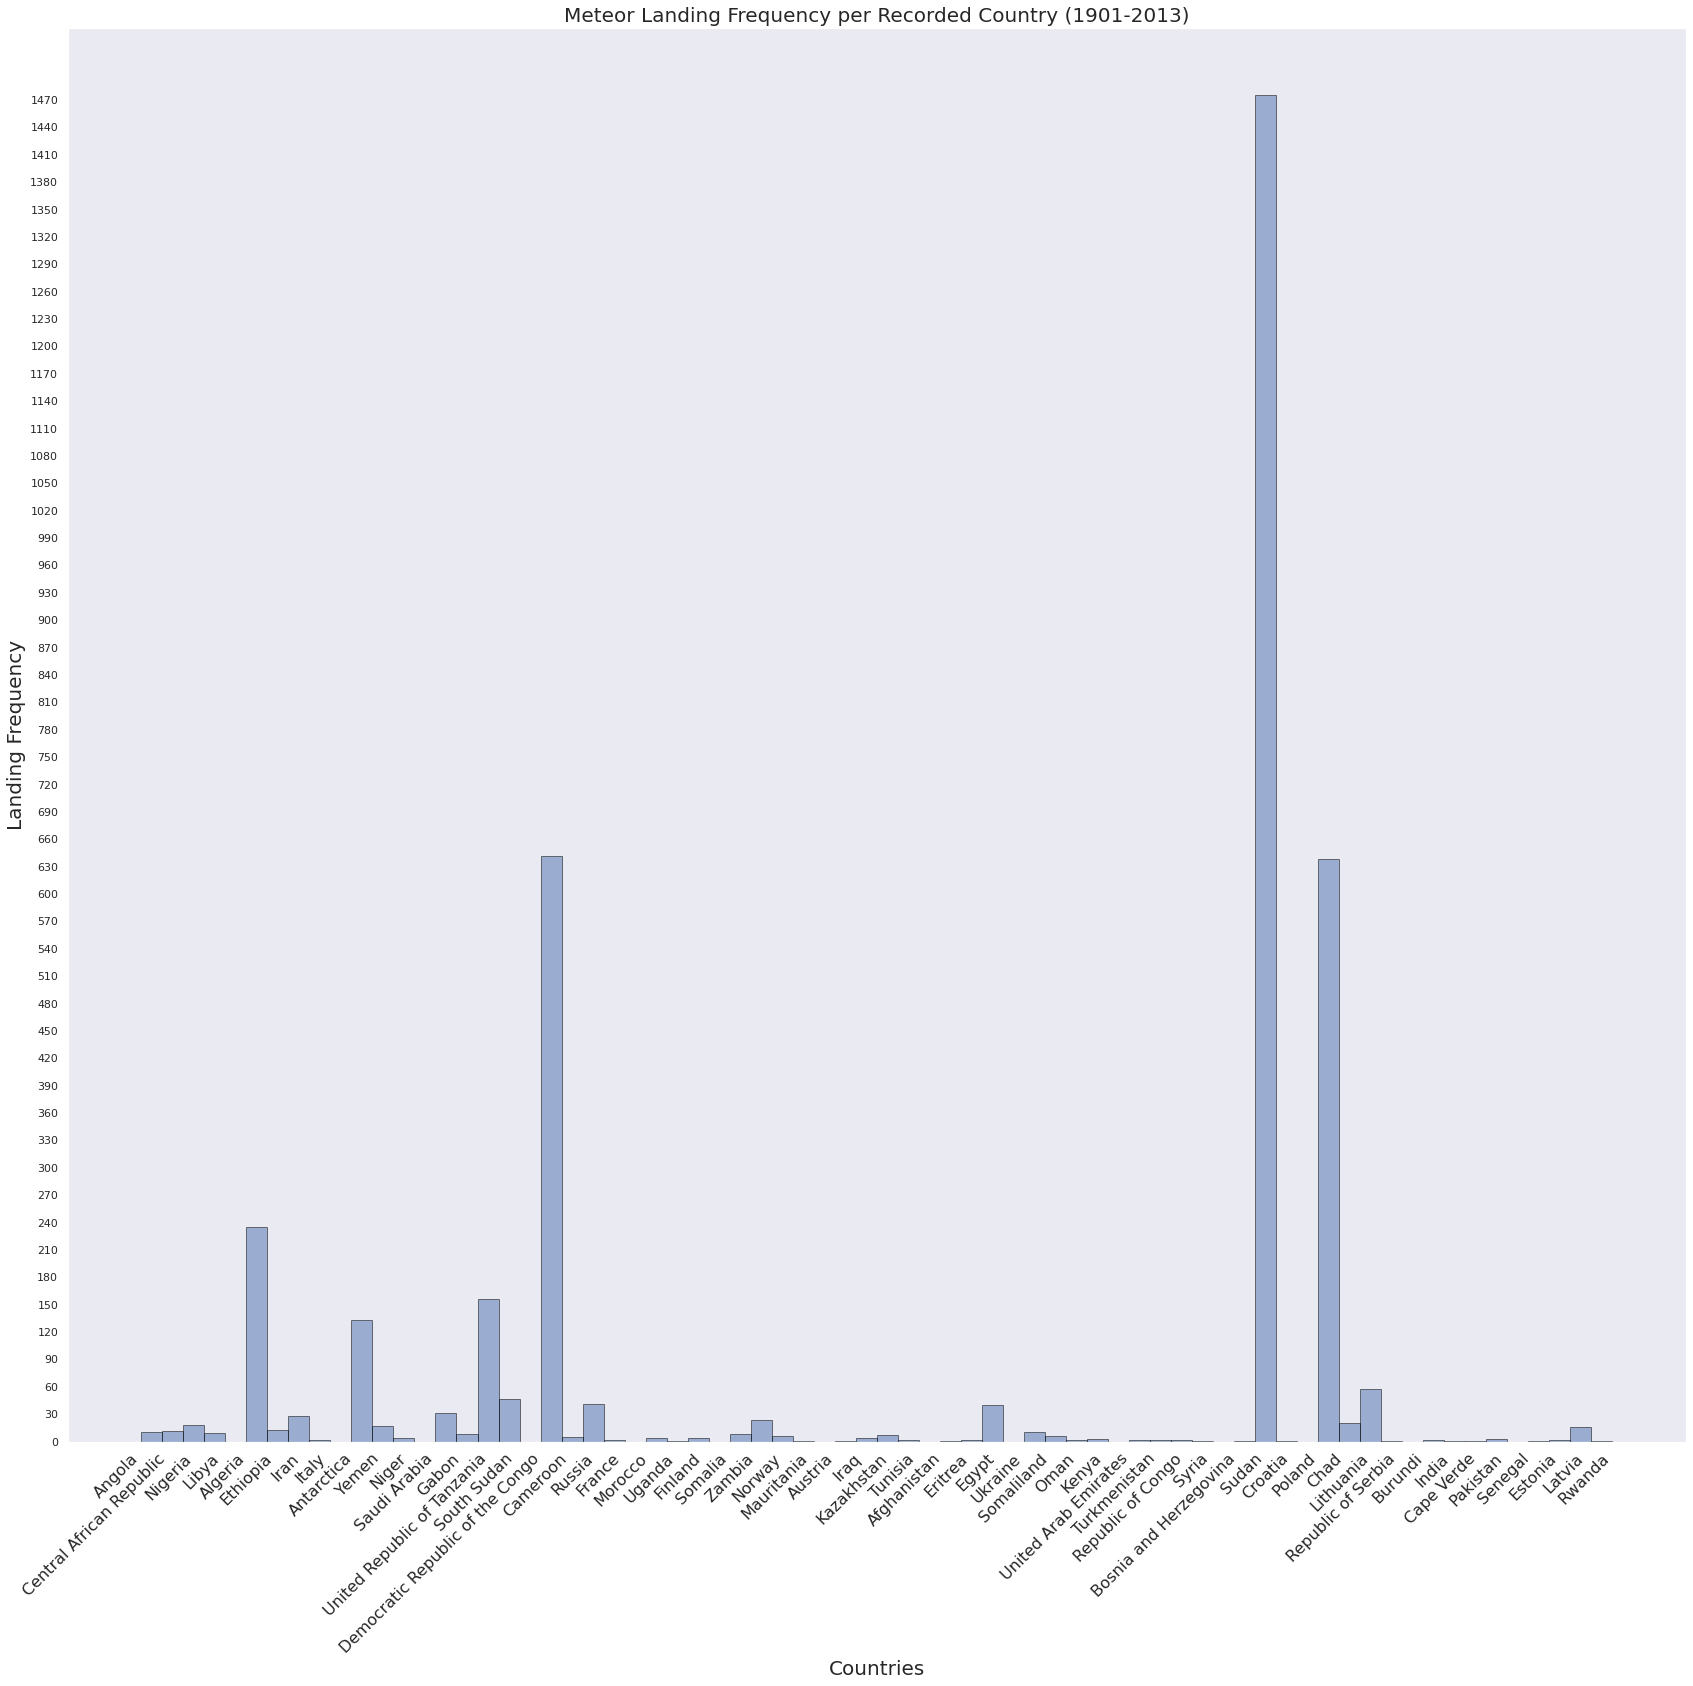

In [117]:
# Displays bar chart to show country's with landings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (29,26)

plt.hist(df['country'], bins=70, alpha=0.5, histtype='bar', ec='black');
plt.grid()
plt.yticks(np.arange(0, 1500, 30))

plt.xticks(
    rotation=45, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 16
)

plt.ylabel('Landing Frequency', size=20)
plt.xlabel('Countries', size=20)
plt.title('Meteor Landing Frequency per Recorded Country (1901-2013)', size=20)
plt.show()

In [118]:
cols = ['red', 'green', 'blue', 'orange', 'yellow', 'purple']

In [119]:
import folium

def mapping(df, cluster_column):
    m = folium.Map(location=[df.reclat.mean(), df.reclong.mean()], zoom_start=2)
    for index, row in df.iterrows():
      if row[cluster_column] == -1: # outlier
            cluster_colour = 'black'
      else:
            cluster_colour = cols[row[cluster_column]]
  
      folium.CircleMarker(
            location= [row['reclat'], row['reclong']],
            radius=3,
            popup= row['Description'],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

In [120]:
import geopandas
from sklearn.cluster import DBSCAN

# since we have date up to 2013 we can assume it will not be updated any tiem soon, so we will manually calculate the eps and minvalues by testing it
geocoords = df[['reclat', 'reclong']].values.tolist()
db = DBSCAN(eps=0.1, min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(geocoords))

class_predictions = db.labels_
df['db_labels'] = class_predictions
m = mapping(df, 'db_labels')

m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [121]:
df

id nametype  ...                   country  db_labels
name                              ...                                     
Aioun el Atrouss    423    Valid  ...                    Angola         -1
Aïr                 424    Valid  ...  Central African Republic          0
Akwanga             432    Valid  ...                   Nigeria         -1
Al Zarnkh           447    Valid  ...                     Libya         -1
Alberta             454    Valid  ...                   Algeria         -1
...                 ...      ...  ...                       ...        ...
Zerhamra          30403    Valid  ...                    Rwanda          0
Zillah 001        31355    Valid  ...                     Sudan          0
Zillah 002        31356    Valid  ...                     Sudan          0
Zinder            30409    Valid  ...                  Cameroon          0
Zlin              30410    Valid  ...                     Yemen          2

[3765 rows x 13 columns]

In [122]:
# https://sne.space/
# lets see if there were supernovas during the years of asteroids hitting earth
df2 = pd.read_csv('The Open Supernova Catalog (1).csv', index_col=0)
df2 = df2.dropna(subset=['Disc. Date']) # dropping all null rows that dont contain a date
df2 = df2.drop(['R.A.', 'Dec.', 'Type', 'Phot.', 'Spec.', 'Radio', 'X-ray', 'mmax'], axis=1) # stuff we dont care about

In [123]:
df2

Disc. Date     Host Name
Name                              
SN2011fe  2011/08/24          M101
SN1987A   1987/02/24           LMC
SN2003dh  2003/03/31  A104450+2131
SN2013dy  2013/07/10      NGC 7250
SN2013ej  2013/07/25       NGC 628
...              ...           ...
SN1985M   1985/06/16  A220830-4830
SN1988M   1988/04/07     NGC 4496B
SN386A     386/04/30     Milky Way
SN393A     393/02/27     Milky Way
SN837A     837/04/29     Milky Way

[89617 rows x 2 columns]

In [124]:
# Lets break up year column into just years
year = list()

for index, row in df2.iterrows():
  year.append(row['Disc. Date'][:4])

In [125]:
from operator import contains
# getting rid of invalid years

df2['years'] = year
df2 = df2[df2.years.str.contains("^19|20\d{2}$")]


In [126]:
#let's drop years before 1490 and after 2013 to match years in df
df2["years"] = pd.to_numeric(df2["years"])
df2 = df2.loc[df2.years < 2014]

df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Disc. Date     Host Name  years
Name                                     
SN2011fe  2011/08/24          M101   2011
SN1987A   1987/02/24           LMC   1987
SN2003dh  2003/03/31  A104450+2131   2003
SN2013dy  2013/07/10      NGC 7250   2013
SN2013ej  2013/07/25       NGC 628   2013

Lets look at frequencies of meteroites

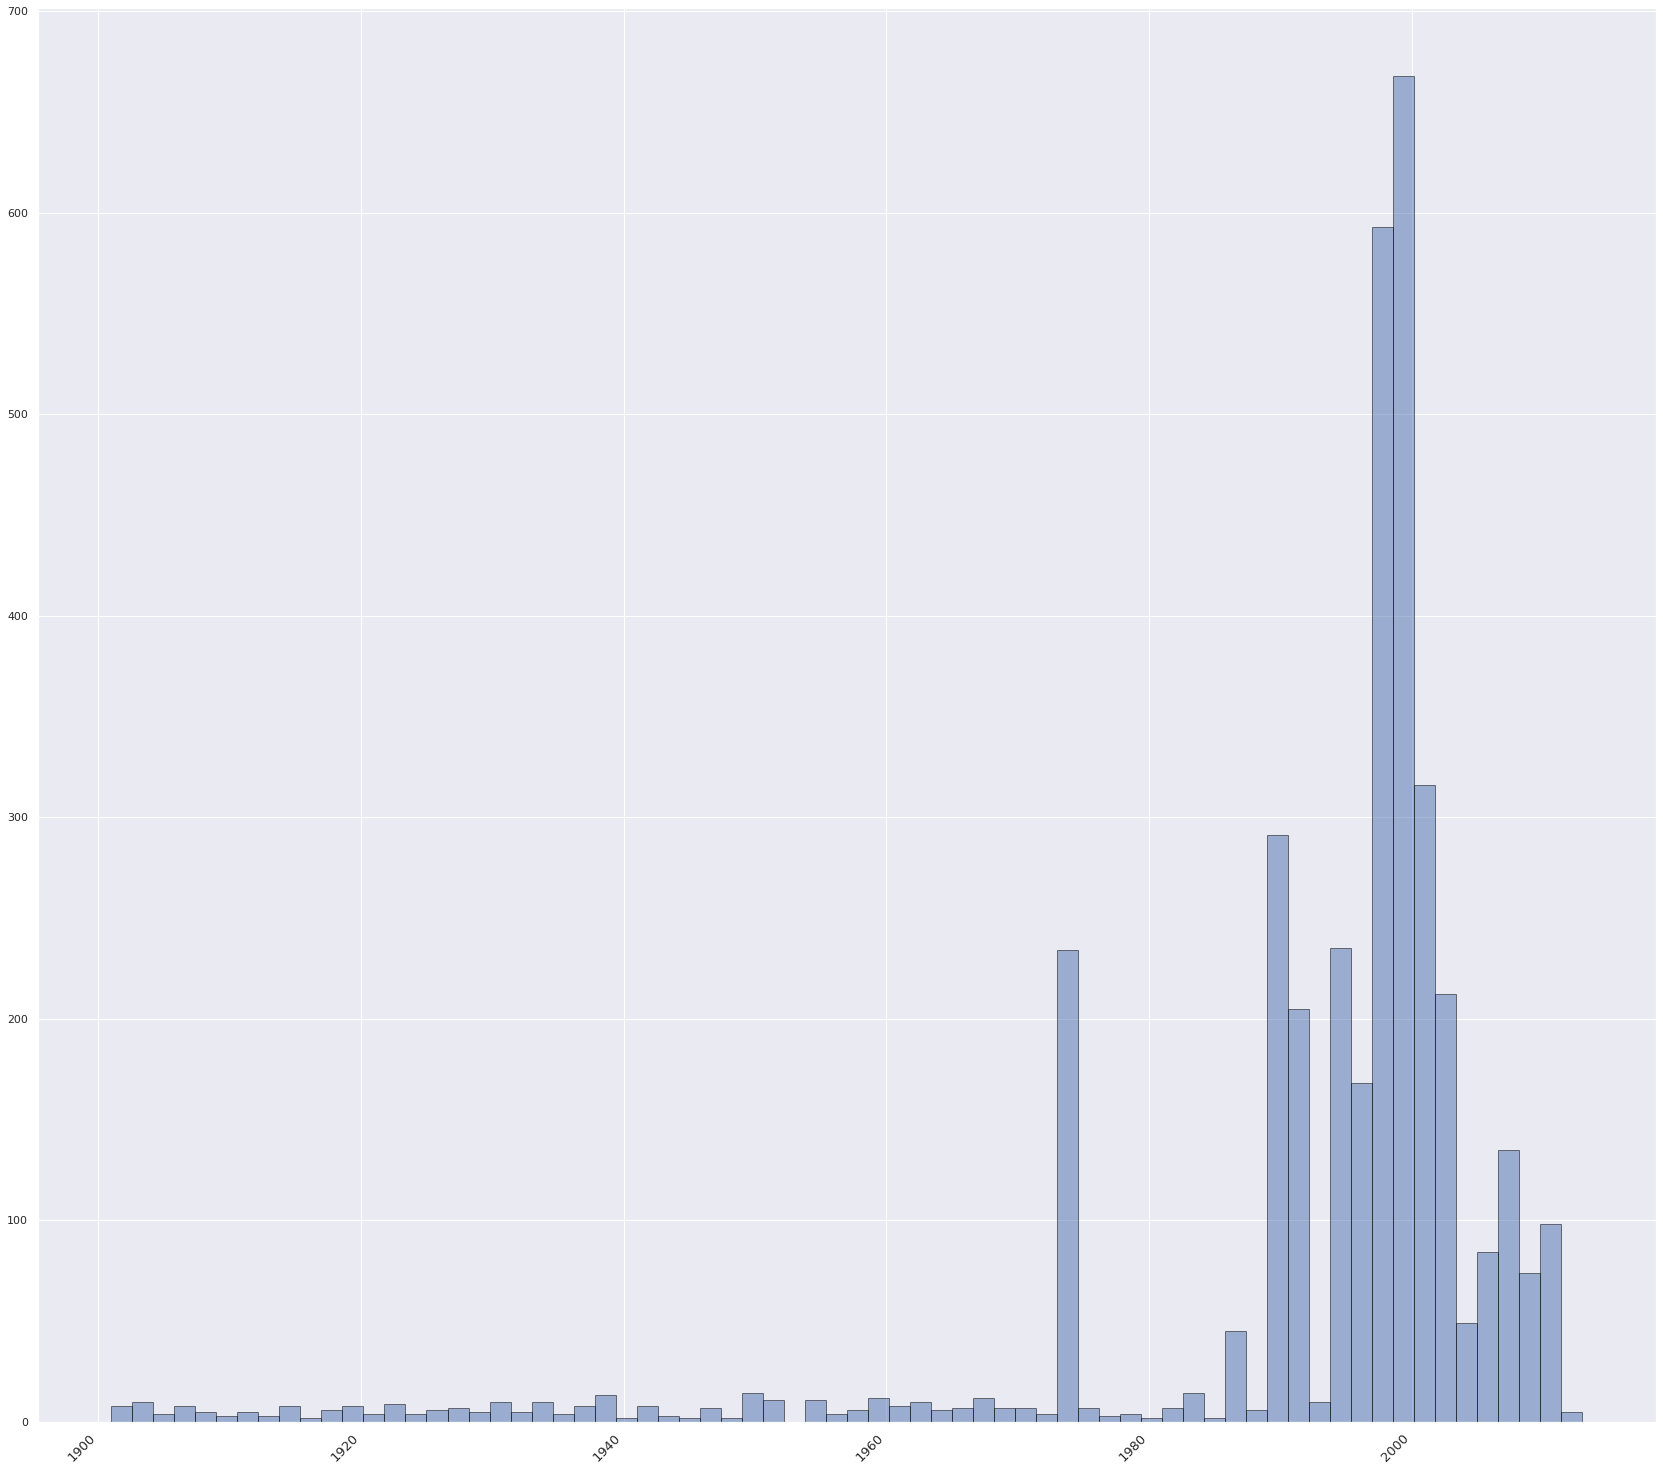

In [127]:
# now lets look at overall meterotie landing fren
plt.xticks(
    rotation=45, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 13
)

plt.hist(df['years'], bins=70, alpha=0.5, histtype='bar', ec='black')
plt.show();

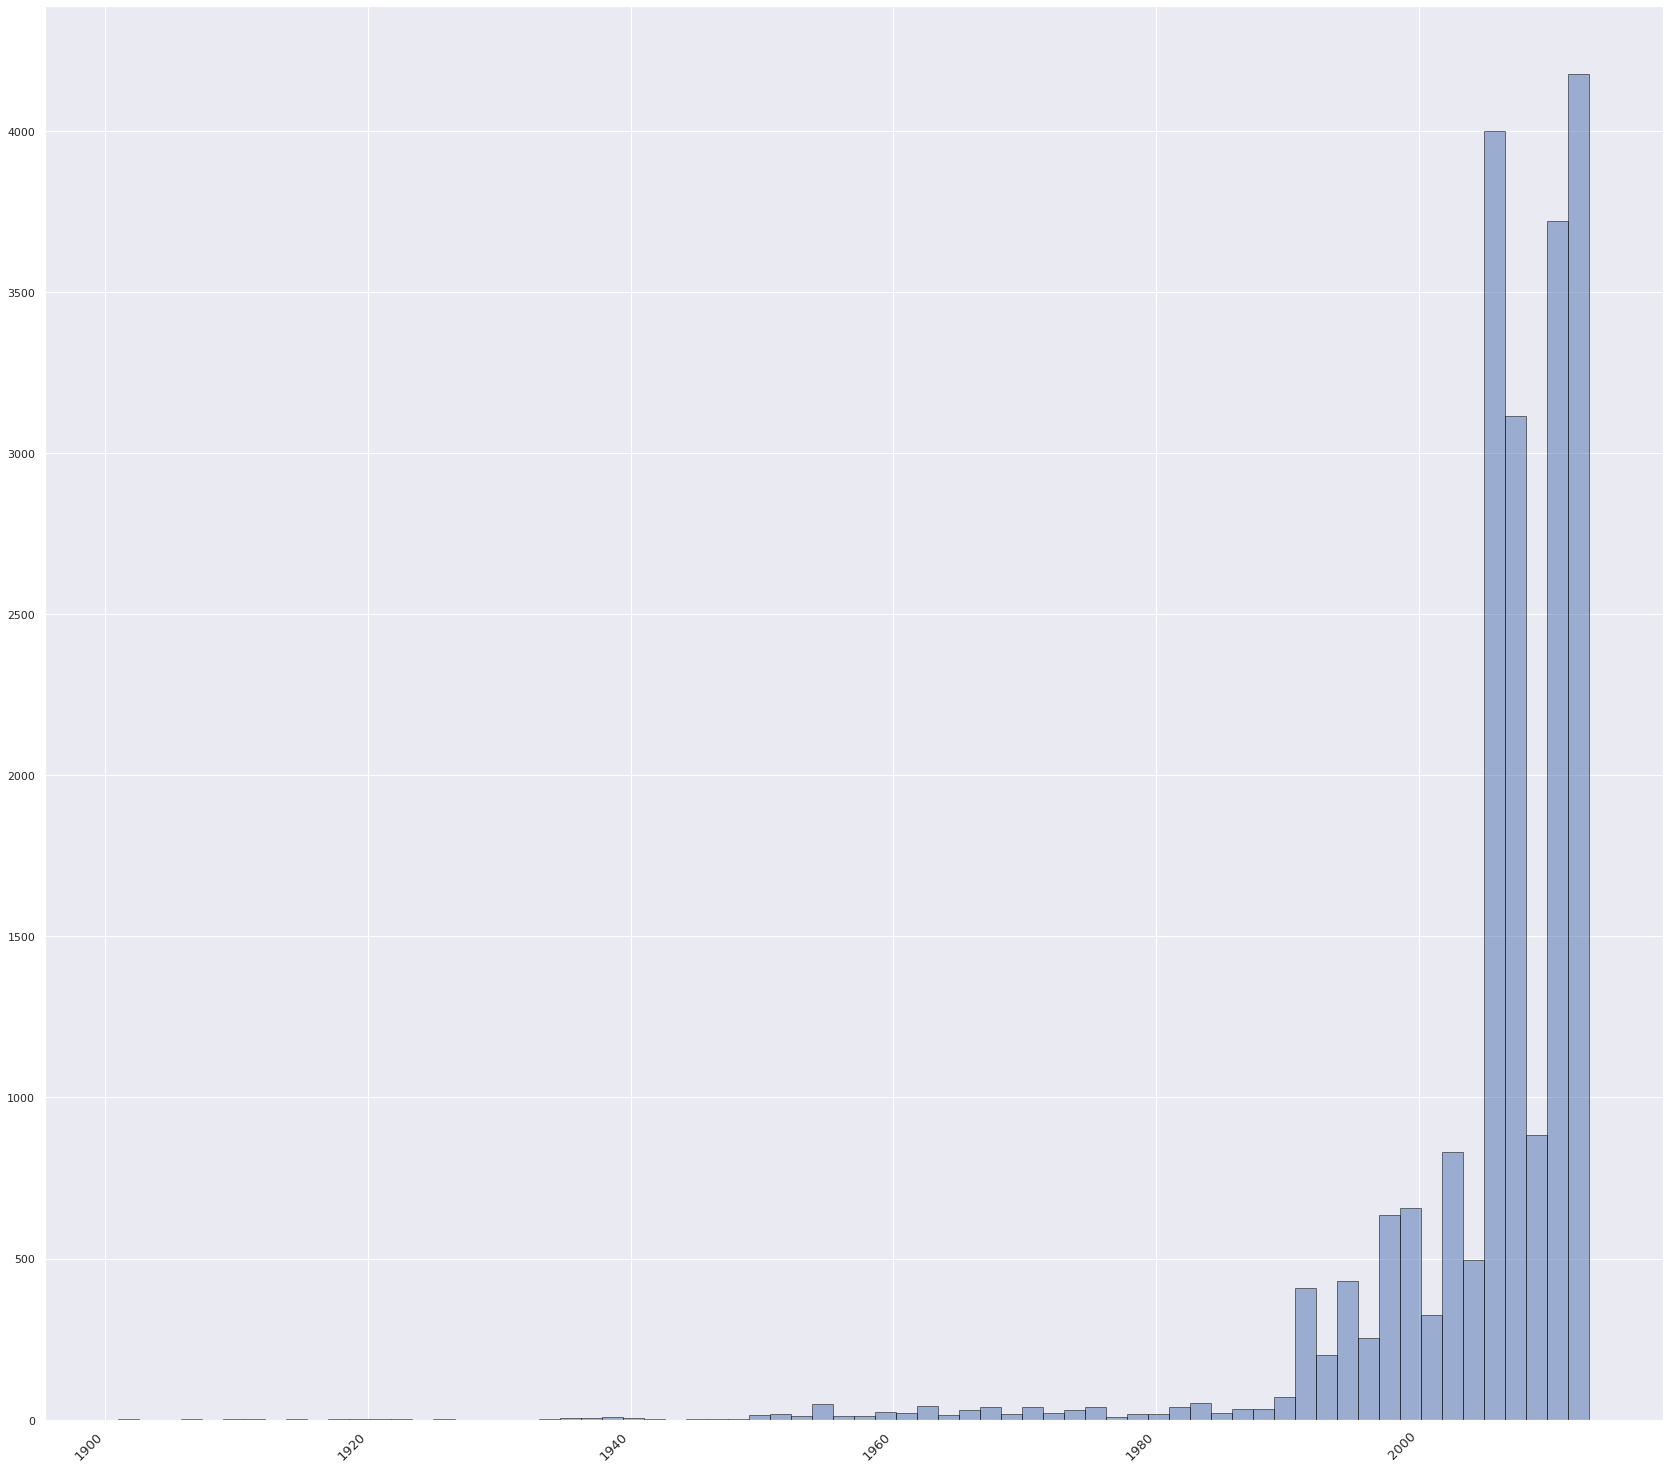

In [128]:
# now lets look at overall supernova landing frequency
df2 = df2.sort_values(by="years")

plt.xticks(
    rotation=45, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 13
)

plt.hist(df2['years'], bins=70, alpha=0.5, histtype='bar', ec='black')
plt.show();

Looks likwe theres some correlation?

Fun fact: asteroids (that later become meteroites) acctually come from supernovas! hmmm

In [129]:
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()

df_1["supernovas"] = df2["years"].value_counts()
df_1 = df_1.reset_index()
df_1 = df_1.rename(columns={"index": "years"})
df_1 = df_1.sort_values(by="years")


df_2["meteorites"] = df["years"].value_counts()
df_2 = df_2.reset_index()
df_2 = df_2.rename(columns={"index": "years"})
df_2 = df_2.sort_values(by="years")

df_major = pd.merge(df_1, df_2, on=["years"])

In [130]:
df_major

years  supernovas  meteorites
0    1901           2           4
1    1907           1           5
2    1912           1           1
3    1914           1           5
4    1915           1           3
..    ...         ...         ...
81   2009         882          74
82   2010        1985          63
83   2011        1734          35
84   2012        1691           4
85   2013        2486           1

[86 rows x 3 columns]

In [131]:
# fitting to linear regression equation 
import statsmodels.api as sm
from statsmodels.formula.api import ols

fit = np.polyfit(df_major["supernovas"].astype(int), df_major["meteorites"],1)
x = fit[0]
intercept = fit[1]
y = x*(df_major["supernovas"]) + intercept

print('y = {:.2f} * supernovas + ({:.2f})'.format(x, intercept))

result = ols(formula = "meteorites ~ supernovas", data=df_major).fit()
print(result.summary())

y = 0.02 * supernovas + (37.96)
                            OLS Regression Results                            
Dep. Variable:             meteorites   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.442
Date:                Mon, 20 Dec 2021   Prob (F-statistic):              0.233
Time:                        07:01:29   Log-Likelihood:                -501.32
No. Observations:                  86   AIC:                             1007.
Df Residuals:                      84   BIC:                             1012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.959

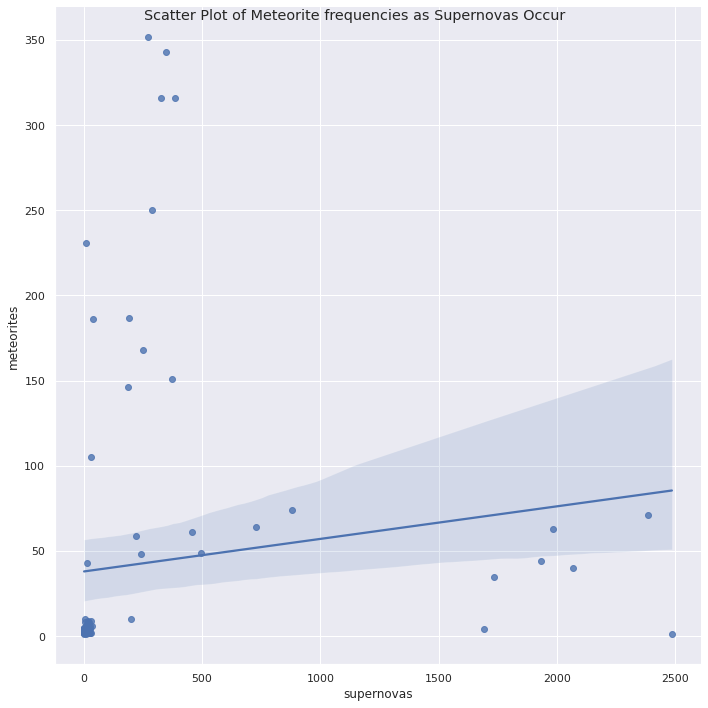

In [132]:
sns.set(rc = {'figure.figsize':(20,8)})
ax = sns.lmplot(x="supernovas", y="meteorites", data=df_major, height=10);

ax.fig.suptitle("Scatter Plot of Meteorite frequencies as Supernovas Occur");